In [1]:
import sys

SAVE_ATTACKS=True #set to true if you want to save generated attacks
SAVE_TRAIN_TEST=True #set to true if you want to save train test splits

In [4]:
import tensorflow as tf
print(tf.__version__)

1.15.5


In [5]:
import sys, os, time, glob, joblib, random, itertools, PIL
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn import ensemble
from sklearn import metrics
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from matplotlib import cm
from time import time
import pyod
from pyod.models.copod import COPOD
from pyod.models.cblof import CBLOF
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.vae import VAE
#from pyod.models.deep_svdd import DeepSVDD
import seaborn as sns
import tensorflow as tf

from sbo import soft_brownian_offset
from sbo import gaussian_hyperspheric_offset
import pylab as plt

from IPython import display
from itertools import combinations
#necessary to avoid growth of jupyter
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Using TensorFlow backend.


In [6]:
PATH='/data/notebook/ganzata_data/'
cicids_competitors=open(PATH+"cicids_competitors.csv", "a")
cicids_competitors.write('dataset, '+
                       'generation technique, '+
                       'classifier, '+
                       'train-test split, '+
                       '# normal in training set, '+
                       '# original attack in training set, '+
                       '# generated attack in training set, '+
                       '# normal in test set, '+
                       '# attacks in test set, '+
                       ' features (columns) - may be 1-hotted, '+
                       ' generated attack is manipulated, '+
                       'tp, tn, fp, fn, accuracy, mcc \n')

cicids_competitors.flush()

In [7]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    if(value_range!=0):
        return starts_from_zero / value_range
    else:
        return starts_from_zero

def compute_TSNE(perplexity,X_data):
    tsne =TSNE(n_components=2, perplexity=perplexity,
     early_exaggeration=12.0, #learning_rate='auto',
     n_iter=1000, n_iter_without_progress=300,
     min_grad_norm=1e-07, metric='euclidean',#init='pca',
     verbose=0, 
     method='barnes_hut', angle=0.5, n_jobs=12).fit_transform(X_data)
    
    # extract x and y coordinates representing the positions of the images on T-SNE plot
    tx = tsne[:, 0]
    ty = tsne[:, 1]

    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)
    return tx, ty

In [8]:
from sklearn.metrics import pairwise_distances
from tqdm import tqdm

def soft_brownian_offset_1(X, d_min, d_off, n_samples=1, show_progress=False, softness=False,
                         random_state=None):
    """Generates OOD samples using SBO on the input X and returns n_samples number of samples constrained by
    other parameters.
    Args:
        X (:obj:`numpy.array`): In-distribution (ID) data to form OOD samples around. First dimension contains samples
        d_min (float): (Likely) Minimum distance to ID data
        d_off (float): Offset distance used in each iteration
        n_samples(int): Number of samples to return
        show_progress(boolean): Whether to show a tqdm progress bar
        softness(float): Describes softness of minimum distance. Parameter between 0 (hard) and 1 (soft)
        random_state(int): RNG state used for reproducibility
    Returns:
        :obj:`numpy.array`:
            Out of distribution samples of shape (n_samples, X.shape[1])
    """
    if softness == 0:
        softness = False
    if random_state is not None:
        np.random.seed(random_state)
    n_dim = X.shape[1]
    ys = []
    iterator = range(n_samples)
    if show_progress:
        iterator = tqdm(iterator)
    for i in iterator:
        # Sample uniformly from X
        y = X[np.random.choice(len(X))].astype(float)
        # Move out of reach of other points
        skip = False
        while True:
            dist = pairwise_distances(y[:, None].T, X)[0]
            if dist.min() > 0:
                if not softness and dist.min() > d_min:
                    skip = True
                elif softness > 0:
                    p = 1 / (1 + np.exp((-dist.min() + d_min) / softness / d_min * 7))
                    if np.random.uniform() < p:
                        skip = True
                elif not isinstance(softness, bool):
                    raise ValueError("Softness should be float greater zero")
            if skip:
                break
            y += gaussian_hyperspheric_offset(1, n_dim=n_dim)[0] * d_off
        ys.append(np.array(y))
    return np.array(ys)

In [9]:
CICIDS=pd.read_csv("./datasets/CICIDS18_Shuffled_Reduced.csv")
CICIDS.replace([np.inf, -np.inf], np.nan, inplace=True)
CICIDS.fillna(0, inplace=True)
CICIDS=CICIDS.drop(columns=["Timestamp"])
CICIDS['label'] =CICIDS['label'].replace(['normal'],0)
CICIDS.loc[CICIDS["label"] !=0, "label"] = 1
CICIDS=CICIDS.apply(pd.to_numeric)
Y=CICIDS['label']
CICIDS

,Protocol,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,Fwd_Pkt_Len_Mean,Fwd_Pkt_Len_Std,...,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,label
0,6,4368867,5,3,935,343,935,0,187.000000,418.144712,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,6,6157,3,4,289,935,289,0,96.333333,166.854228,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,6,48,2,0,0,0,0,0,0.000000,0.000000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,6,6,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,6,2,1,1,0,0,0,0,0.000000,0.000000,...,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199992,6,6,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
199993,6,1393225,8,7,1132,1581,661,0,141.500000,222.792023,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
199994,6,5277048,5,3,935,364,935,0,187.000000,418.144712,...,32,0.0,0.0,0.0,0.0,5205095.0,0.0,5205095.0,5205095.0,0
199995,6,933,2,0,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [11]:
#CICIDS_X and CICIDS_Y have only normal
CICIDS_X=CICIDS[CICIDS['label']==0]
CICIDS_attacks=CICIDS[CICIDS['label']!=0]

CICIDS_X=CICIDS_X.apply(pd.to_numeric)
CICIDS_attacks=CICIDS_attacks.apply(pd.to_numeric)

CICIDS_Y=CICIDS_X['label'].to_numpy()
CICIDS_attack_Y=CICIDS_attacks['label'].to_numpy()

CICIDS_X=CICIDS_X.drop(columns=['label'])
CICIDS_attacks=CICIDS_attacks.drop(columns=['label'])
CICIDS=CICIDS.drop(columns=["label"])

CICIDS.shape, CICIDS_X.shape, CICIDS_attacks.shape

((199997, 77), (67494, 77), (132503, 77))

In [15]:
#here just to reuse previous variable names...
CICIDS_X=CICIDS
CICIDS_Y=Y

In [16]:
enc = OneHotEncoder(handle_unknown='ignore')

array= pd.DataFrame().assign(A=CICIDS_X['Protocol'],
                             B=CICIDS_X['Fwd_PSH_Flags'],
                             C=CICIDS_X['Bwd_PSH_Flags'], 
                             D=CICIDS_X['Fwd_URG_Flags'],
                             E=CICIDS_X['Bwd_URG_Flags'],
                             F=CICIDS_X['FIN_Flag_Cnt'],
                             G=CICIDS_X['SYN_Flag_Cnt'],
                             H=CICIDS_X['RST_Flag_Cnt'],
                             I=CICIDS_X['PSH_Flag_Cnt'],
                             J=CICIDS_X['ACK_Flag_Cnt'],
                             K=CICIDS_X['URG_Flag_Cnt'],
                             L=CICIDS_X['CWE_Flag_Count'],
                             M=CICIDS_X['ECE_Flag_Cnt'],
                             N=CICIDS_X['DownUp_Ratio'],
                             P=CICIDS_X['Fwd_Bytsb_Avg'],
                             Q=CICIDS_X['Fwd_Pktsb_Avg'],
                             R=CICIDS_X['Fwd_Blk_Rate_Avg'],
                             S=CICIDS_X['Bwd_Bytsb_Avg'],
                             T=CICIDS_X['Bwd_Pktsb_Avg'],
                             U=CICIDS_X['Bwd_Blk_Rate_Avg'],    

                            )
array.shape

(199997, 20)

In [17]:
#enc=enc.fit(array)
enc.fit(array)
encoded=enc.transform(array).toarray()
encoded.shape, array.shape

((199997, 44), (199997, 20))

In [18]:
CICIDS_X = CICIDS_X.join(pd.DataFrame(encoded))
CICIDS_X.shape

(199997, 121)

In [19]:
CICIDS_train_X, CICIDS_test_X, CICIDS_train_Y, CICIDS_test_Y = train_test_split(CICIDS_X,CICIDS_Y, 
                                                                                    test_size=0.4, 
                                                                                    shuffle=True)

contamination= (np.sum(CICIDS_train_Y.to_numpy(), axis=0)/CICIDS_train_Y.to_numpy().shape[0])
normal_values= (CICIDS_train_Y.to_numpy().shape[0]-np.sum(CICIDS_train_Y.to_numpy(), axis=0))

print("train size, test size, contamination in train")
CICIDS_train_X.shape, CICIDS_test_X.shape, contamination, normal_values

train size, test size, contamination in train


((119998, 121), (79999, 121), 0.6643277387956465, 40280)

We try xgboost in a fully supervised setting

In [20]:
xb=xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False )
xb.fit(CICIDS_train_X, CICIDS_train_Y)
predicted=xb.predict(CICIDS_test_X)

In [21]:
accuracy=accuracy_score(CICIDS_test_Y, predicted)
tn, fp, fn, tp = confusion_matrix(CICIDS_test_Y, predicted).ravel()
mcc=matthews_corrcoef(CICIDS_test_Y, predicted)
print("tp, tn, fp, fn, accuracy, mcc:")
tp, tn, fp, fn, accuracy, mcc

tp, tn, fp, fn, accuracy, mcc:


(50287, 27007, 207, 2498, 0.9661870773384668, 0.927999058817142)

In [22]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_Y, return_counts=True)[1][0]
original_attack_in_training_set=np.unique(CICIDS_train_Y, return_counts=True)[1][1]
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
cicids_competitors.write(dataset+', '+
                       'all known, '+
                       'xgboost, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       '0, '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' NO GENERATED ATTACK, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

... and random forests

In [23]:
clf= RandomForestClassifier(n_estimators=500, 
                                             criterion='gini',
                                             max_depth=None,
                                             min_samples_split=2,
                                             min_samples_leaf=1,
                                             min_weight_fraction_leaf=0.0,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             bootstrap=True,
                                             oob_score=False,
                                             n_jobs=12,
                                             random_state=42,
                                             verbose=0,
                                             warm_start=False,
                                             class_weight=None,
                                             ccp_alpha=0.0,
                                             max_samples=None)


clf.fit(CICIDS_train_X, CICIDS_train_Y)

predicted=clf.predict(CICIDS_test_X)

In [24]:
accuracy=accuracy_score(CICIDS_test_Y, predicted)
tn, fp, fn, tp = confusion_matrix(CICIDS_test_Y, predicted).ravel()
mcc=matthews_corrcoef(CICIDS_test_Y, predicted)
print("tp, tn, fp, fn, accuracy, mcc:")
tp, tn, fp, fn, accuracy, mcc

tp, tn, fp, fn, accuracy, mcc:


(50504, 26336, 878, 2281, 0.96051200640008, 0.9138021254056005)

In [25]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_Y, return_counts=True)[1][0]
original_attack_in_training_set=np.unique(CICIDS_train_Y, return_counts=True)[1][1]
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
cicids_competitors.write(dataset+', '+
                       'all known, '+
                       'RandomForest, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       '0, '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' NO GENERATED ATTACK, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

We reduce contamination below target value to run the unsupervised and semisupervised

In [26]:
TARGET_MAX_CONTAMINATION=0.5

In [27]:
concatenated = pd.concat([CICIDS_train_X, CICIDS_train_Y], axis=1, join='inner')
concatenated.shape

(119998, 122)

In [28]:
int(round(normal_values*TARGET_MAX_CONTAMINATION-1))

20139

In [29]:
#reduce the number of attacks in training set, to run the unsupervised
if(contamination > 0.5):
    selected=concatenated.query('(label == 1)').sample(n=int(round(normal_values*TARGET_MAX_CONTAMINATION-1)))
    contamination = 0.5

selected.shape

(20139, 122)

In [30]:
concatenated

,Protocol,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,Fwd_Pkt_Len_Mean,Fwd_Pkt_Len_Std,...,35,36,37,38,39,40,41,42,43,label
18621,6,3,1,1,0,0,0,0,0.000000,0.000000,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1
27056,6,367904,22,22,1912,2665,640,0,86.909091,137.688022,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1
128412,6,3131,3,0,77,0,46,0,25.666667,23.459184,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0
48158,6,1409077,8,7,1148,1581,677,0,143.500000,228.129662,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0
40690,6,547,2,0,0,0,0,0,0.000000,0.000000,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181333,6,3,1,1,0,0,0,0,0.000000,0.000000,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1
106443,6,1344,2,0,0,0,0,0,0.000000,0.000000,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1
140236,6,1,1,1,0,0,0,0,0.000000,0.000000,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1
176613,6,10663,3,4,274,935,274,0,91.333333,158.193974,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1


In [31]:
concatenated=concatenated[concatenated['label']==0]
frames = [concatenated,selected]

CICIDS_train_X = pd.concat(frames)
CICIDS_train_Y=CICIDS_train_X['label']
CICIDS_train_X=CICIDS_train_X.drop(columns=['label'])
CICIDS_train_X.shape, np.unique(CICIDS_train_Y, return_counts=True)

((60419, 121), (array([0, 1]), array([40280, 20139])))

We try Isolation Forest (unsupervised)

In [32]:
isol=IsolationForest(n_estimators=300,
                     max_samples='auto',
                     contamination=contamination,
                     max_features=1.0,
                     bootstrap=False,
                     n_jobs=12,warm_start=False).fit(CICIDS_train_X.to_numpy())

In [33]:
predicted=isol.predict(CICIDS_test_X.to_numpy())

In [34]:
predicted.shape, CICIDS_test_X.shape, CICIDS_test_Y.shape, np.unique(CICIDS_test_Y, return_counts=True)

((79999,), (79999, 121), (79999,), (array([0, 1]), array([27214, 52785])))

In [35]:
predicted=np.where(predicted==-1, 1, 0)
accuracy=accuracy_score(CICIDS_test_Y.to_numpy(), predicted)
mcc=matthews_corrcoef(CICIDS_test_Y.to_numpy(), predicted)
tn, fp, fn, tp= confusion_matrix(CICIDS_test_Y.to_numpy(), predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(29583, 14376, 12838, 23202, 0.5494943686796085, 0.08420188556948278)

In [36]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_Y, return_counts=True)[1][0]
original_attack_in_training_set=np.unique(CICIDS_train_Y, return_counts=True)[1][1]
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
cicids_competitors.write(dataset+', '+
                       'all known, '+
                       'IsolationForest, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       '0, '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' NO GENERATED ATTACK, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

We try also COPOD and CBLOF

In [37]:
clf = COPOD(contamination=contamination, n_jobs=12)
clf.fit(CICIDS_train_X.to_numpy())
predicted = clf.predict(CICIDS_test_X.to_numpy())  # outlier labels (0 or 1)
Y=CICIDS_test_Y.to_numpy()
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    1.4s remaining:    6.8s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.5s remaining:    2.3s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.8s finished


(13051, 3451, 23763, 39734, 0.20627757846973088, -0.5949939904841095)

In [38]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_Y, return_counts=True)[1][0]
original_attack_in_training_set=np.unique(CICIDS_train_Y, return_counts=True)[1][1]
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
cicids_competitors.write(dataset+', '+
                       'all known, '+
                       'Copod, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       '0, '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' NO GENERATED ATTACK, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

In [39]:
clf = CBLOF(contamination=contamination, n_jobs=12) # n_clusters=8
clf.fit(CICIDS_train_X.to_numpy())
predicted = clf.predict(CICIDS_test_X.to_numpy())  # outlier labels (0 or 1)
Y=CICIDS_test_Y.to_numpy()
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(3609, 7758, 19456, 49176, 0.14208927611595146, -0.6762292882351941)

In [40]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_Y, return_counts=True)[1][0]
original_attack_in_training_set=np.unique(CICIDS_train_Y, return_counts=True)[1][1]
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
cicids_competitors.write(dataset+', '+
                       'all known, '+
                       'CBLOF, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       '0, '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' NO GENERATED ATTACK, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

and one class-SVM

In [41]:
from sklearn.svm import OneClassSVM
svm_clf=OneClassSVM(kernel='rbf',
                    degree=3,
                    gamma='scale',
                    coef0=0.0,
                    tol=0.001,
                    nu=0.5,
                    shrinking=False,
                    cache_size=600,
                    verbose=False,
                    max_iter=-1).fit(CICIDS_train_X.to_numpy())

predicted= svm_clf.predict(CICIDS_test_X.to_numpy())

Y=CICIDS_test_Y.to_numpy()
predicted=np.where(predicted==-1, 1, 0)
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc


(21531, 12496, 14718, 31254, 0.4253428167852098, -0.12650852277754868)

In [42]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_Y, return_counts=True)[1][0]
original_attack_in_training_set=np.unique(CICIDS_train_Y, return_counts=True)[1][1]
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
cicids_competitors.write(dataset+', '+
                       'all known, '+
                       'SVM, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       '0, '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' NO GENERATED ATTACK, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

We now test autoencoders from PYOD: AutoEncoder, VAE

In [44]:
clf=AutoEncoder(hidden_neurons=[3, 16, 16, 3], #default=[64, 32, 32, 64]
                hidden_activation='relu', output_activation='sigmoid',
                optimizer='adam', epochs=100, batch_size=1024,
                dropout_rate=0.2, l2_regularizer=0.1,
                validation_size=0.1,
                preprocessing=True,
                verbose=1,
                random_state=None,
                contamination=contamination)

clf.fit(CICIDS_train_X.to_numpy())
predicted = clf.predict(CICIDS_test_X.to_numpy())  # outlier labels (0 or 1)
Y=CICIDS_test_Y.to_numpy()
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 121)               14762     
_________________________________________________________________
dropout_1 (Dropout)          (None, 121)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 121)               14762     
_________________________________________________________________
dropout_2 (Dropout)          (None, 121)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 366       
_________________________________________________________________
dropout_3 (Dropout)          (None, 3)                 0         
_______________________________________

2023-01-19 20:03:30.974180: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-01-19 20:03:31.005676: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3900000000 Hz
2023-01-19 20:03:31.006718: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55c5b15164e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-01-19 20:03:31.006742: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version



Train on 54377 samples, validate on 6042 samples
Epoch 1/100
54377/54377 [==============================] - 1s 20us/step - loss: 6074.0325 - val_loss: 3530.0695
Epoch 2/100
54377/54377 [==============================] - 1s 12us/step - loss: 3526.1044 - val_loss: 2487.8048
Epoch 3/100
54377/54377 [==============================] - 1s 12us/step - loss: 2436.4008 - val_loss: 1538.3893
Epoch 4/100
54377/54377 [==============================] - 1s 16us/step - loss: 1734.4398 - val_loss: 1135.4865
Epoch 5/100
54377/54377 [==============================] - 1s 11us/step - loss: 1400.2032 - val_loss: 931.8115
Epoch 6/100
54377/54377 [==============================] - 1s 12us/step - loss: 1185.4784 - val_loss: 800.4691
Epoch 7/100
54377/54377 [==============================] - 1s 12us/step - loss: 1034.3167 - val_loss: 707.7160
Epoch 8/100
54377/54377 [==============================] - 1s 12us/step - loss: 918.3102 - val_loss: 636.7001
Epoch 9/100
54377/54377 [==============================] - 

(36338, 16151, 11063, 16447, 0.6561207015087689, 0.2718015998809331)

In [45]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_Y, return_counts=True)[1][0]
original_attack_in_training_set=np.unique(CICIDS_train_Y, return_counts=True)[1][1]
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
cicids_competitors.write(dataset+', '+
                       'all known, '+
                       'AutoEncoder, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       '0, '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' NO GENERATED ATTACK, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

In [46]:
clf=VAE(encoder_neurons=[3, 64, 32], #(default=[128, 64, 32])
        decoder_neurons=[32, 64, 3], #(default=[32, 64, 128])
        latent_dim=2, hidden_activation='relu', output_activation='sigmoid', 
        optimizer='adam', epochs=60, batch_size=1024, 
        dropout_rate=0.2, l2_regularizer=0.1, validation_size=0.1, 
        preprocessing=True, verbose=1, random_state=None,
        contamination=contamination,
        gamma=1.0, capacity=0.8)

clf.fit(CICIDS_train_X.to_numpy())
predicted = clf.predict(CICIDS_test_X.to_numpy())  # outlier labels (0 or 1)
Y=CICIDS_test_Y.to_numpy()
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 121)          0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 121)          14762       input_1[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 3)            366         dense_8[0][0]                    
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 3)            0           dense_9[0][0]                    
____________________________________________________________________________________________

(36433, 16179, 11035, 16352, 0.6576582207277591, 0.27461748717319545)

In [47]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_Y, return_counts=True)[1][0]
original_attack_in_training_set=np.unique(CICIDS_train_Y, return_counts=True)[1][1]
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
cicids_competitors.write(dataset+', '+
                       'all known, '+
                       'VAE, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       '0, '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' NO GENERATED ATTACK, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

**From here, there are no attacks in the training set.**

contamination is set to 0 (or default if 0 is not accepted), attacks are removed from the training set

In [48]:
contamination=0.0

CICIDS_train_X_no_attack=pd.concat([CICIDS_train_X, CICIDS_train_Y], axis=1)
CICIDS_train_X_no_attack=CICIDS_train_X_no_attack[CICIDS_train_X_no_attack.label == 0]

In [49]:
CICIDS_train_X_no_attack=CICIDS_train_X_no_attack.drop(['label'], axis=1)
CICIDS_train_X_no_attack.shape

(40280, 121)

In [50]:
isol=IsolationForest(n_estimators=300,
                     max_samples='auto',
                     #contamination=contamination,
                     max_features=1.0,
                     bootstrap=False,
                     n_jobs=12,warm_start=False).fit(CICIDS_train_X_no_attack.to_numpy())

predicted=isol.predict(CICIDS_test_X.to_numpy())

Y=CICIDS_test_Y.to_numpy()
predicted=np.where(predicted==-1, 1, 0)
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(5508, 24163, 3051, 47277, 0.3708921361517019, -0.0118995804614598)

In [51]:
CICIDS_train_X_no_attack.shape[1]

121

In [52]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
cicids_competitors.write(dataset+', '+
                       'no attacks at all, '+
                       'IsolationForest, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       '0, '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' NO GENERATED ATTACK, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

In [53]:
svm_clf=OneClassSVM(kernel='rbf',
                    degree=3,
                    gamma='scale',
                    coef0=0.0,
                    tol=0.001,
                    nu=0.5,
                    shrinking=False,
                    cache_size=600,
                    verbose=False,
                    max_iter=-1).fit(CICIDS_train_X.to_numpy())

predicted= svm_clf.predict(CICIDS_test_X.to_numpy())

Y=CICIDS_test_Y.to_numpy()
predicted=np.where(predicted==-1, 1, 0)
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(21531, 12496, 14718, 31254, 0.4253428167852098, -0.12650852277754868)

In [54]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
cicids_competitors.write(dataset+', '+
                       'no attacks at all, '+
                       'SVM, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       '0, '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' NO GENERATED ATTACK, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

In [55]:
clf = COPOD(n_jobs=12)#contamination=contamination,
clf.fit(CICIDS_train_X_no_attack.to_numpy())
predicted = clf.predict(CICIDS_test_X.to_numpy())  # outlier labels (0 or 1)
Y=CICIDS_test_Y.to_numpy()
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    1.3s remaining:    6.6s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    1.7s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.4s remaining:    2.1s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.8s finished


(777, 24783, 2431, 52008, 0.3195039937999225, -0.1801647936447676)

In [56]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
cicids_competitors.write(dataset+', '+
                       'no attacks at all, '+
                       'COPOD, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       '0, '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' NO GENERATED ATTACK, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

In [57]:
clf = CBLOF(n_jobs=12) # contamination=contamination, n_clusters=8
clf.fit(CICIDS_train_X_no_attack.to_numpy())
predicted = clf.predict(CICIDS_test_X.to_numpy())  # outlier labels (0 or 1)
Y=CICIDS_test_Y.to_numpy()
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(607, 24511, 2703, 52178, 0.3139789247365592, -0.20892292737920598)

In [58]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
cicids_competitors.write(dataset+', '+
                       'no attacks at all, '+
                       'CBLOF, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       '0, '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' NO GENERATED ATTACK, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

In [60]:
clf=AutoEncoder(hidden_neurons=[3, 16, 16, 3], #default=[64, 32, 32, 64]
                hidden_activation='relu', output_activation='sigmoid',
                optimizer='adam', epochs=100, batch_size=1024,
                dropout_rate=0.2, l2_regularizer=0.1,
                validation_size=0.1,
                preprocessing=True,
                verbose=1,
                random_state=None)#,
                #contamination=contamination

clf.fit(CICIDS_train_X_no_attack.to_numpy())
predicted = clf.predict(CICIDS_test_X.to_numpy())  # outlier labels (0 or 1)
Y=CICIDS_test_Y.to_numpy()
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 121)               14762     
_________________________________________________________________
dropout_13 (Dropout)         (None, 121)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 121)               14762     
_________________________________________________________________
dropout_14 (Dropout)         (None, 121)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 366       
_________________________________________________________________
dropout_15 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)               

(8650, 24477, 2737, 44135, 0.41409267615845197, 0.08583099290652785)

In [61]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
cicids_competitors.write(dataset+', '+
                       'no attacks at all, '+
                       'AutoEncoder, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       '0, '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' NO GENERATED ATTACK, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

In [62]:
clf=VAE(encoder_neurons=[3, 64, 32], #(default=[128, 64, 32])
        decoder_neurons=[32, 64, 3], #(default=[32, 64, 128])
        latent_dim=2, hidden_activation='relu', output_activation='sigmoid', 
        optimizer='adam', epochs=60, batch_size=1024, 
        dropout_rate=0.2, l2_regularizer=0.1, validation_size=0.1, 
        preprocessing=True, verbose=1, random_state=None,
        #contamination=contamination,
        gamma=1.0, capacity=0.8)

clf.fit(CICIDS_train_X_no_attack.to_numpy())
predicted = clf.predict(CICIDS_test_X.to_numpy())  # outlier labels (0 or 1)
Y=CICIDS_test_Y.to_numpy()
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 121)          0                                            
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 121)          14762       input_3[0][0]                    
__________________________________________________________________________________________________
dense_27 (Dense)                (None, 3)            366         dense_26[0][0]                   
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 3)            0           dense_27[0][0]                   
____________________________________________________________________________________________

(8544, 24640, 2574, 44241, 0.4148051850648133, 0.09214623172768929)

In [63]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
cicids_competitors.write(dataset+', '+
                       'no attacks at all, '+
                       'VAE, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       '0, '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' NO GENERATED ATTACK, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

**The following are algorithms based on attack generation**

first we  adjust the test set, with all the CICIDS attack.

In [1]:
CICIDS_X.shape, CICIDS_Y.shape, np.unique(CICIDS_Y, return_counts=True)

NameError: name 'CICIDS_X' is not defined

In [65]:
CICIDS_X['label']=CICIDS_Y
CICIDS_X

,Protocol,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,Fwd_Pkt_Len_Mean,Fwd_Pkt_Len_Std,...,35,36,37,38,39,40,41,42,43,label
0,6,4368867,5,3,935,343,935,0,187.000000,418.144712,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0
1,6,6157,3,4,289,935,289,0,96.333333,166.854228,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2,6,48,2,0,0,0,0,0,0.000000,0.000000,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0
3,6,6,1,1,0,0,0,0,0.000000,0.000000,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1
4,6,2,1,1,0,0,0,0,0.000000,0.000000,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199992,6,6,1,1,0,0,0,0,0.000000,0.000000,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1
199993,6,1393225,8,7,1132,1581,661,0,141.500000,222.792023,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0
199994,6,5277048,5,3,935,364,935,0,187.000000,418.144712,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0
199995,6,933,2,0,0,0,0,0,0.000000,0.000000,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1


In [66]:
normal_data=CICIDS_X[CICIDS_X['label']==0]
attack_data=CICIDS_X[CICIDS_X['label']!=0]
normal_data=normal_data.drop(columns=['label'])
attack_data=attack_data.drop(columns=['label'])

In [67]:
X_train, X_test = train_test_split(normal_data,  test_size=0.4, random_state=42)

In [68]:
CICIDS_train_X_no_attack=X_train
frames = [X_test, attack_data]
CICIDS_test_X = pd.concat(frames)
CICIDS_test_Y=np.vstack((np.zeros((X_test.to_numpy().shape[0], 1)), np.ones((attack_data.to_numpy().shape[0], 1))))
CICIDS_test_X.shape, CICIDS_test_Y.shape

((159501, 121), (159501, 1))

In [69]:
if(SAVE_TRAIN_TEST==True):
    np.save('/home/notebook/CICIDS_train_X_no_attack.npy', CICIDS_train_X_no_attack)
    np.save('/home/notebook/CICIDS_test_X.npy', CICIDS_test_X)
    np.save('/home/notebook//CICIDS_test_Y.npy', CICIDS_test_Y)
else:
    CICIDS_train_X_no_attack=np.load('/home/notebook/CICIDS_train_X_no_attack.npy')
    CICIDS_test_X= np.load('/home/notebook/CICIDS_test_X.npy')
    CICIDS_test_Y= np.load('/home/notebook/CICIDS_test_Y.npy')

Soft-Brownian Offset https://github.com/flxai/soft-brownian-offset


Moller, Felix, et al. "Out-of-distribution detection and generation using soft brownian offset sampling and autoencoders." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2021.<

In [70]:
def plot_mindist(X, y, ax=plt):
    if len(X.shape) == 1:
        X = X[:, None]
    if len(y.shape) == 1:
        y = y[:, None]
    ax.hist(pairwise_distances(y, X).min(axis=1), bins=len(y) // 10)
    ax.set_xlabel("Minimum distance from ood to id")
    ax.set_ylabel("Count")

def plot_data_mindist(X, y):
    fig, ax = plt.subplots(1, 2)
    plot_data(X, y, ax=ax[0])
    plot_mindist(X, y, ax=ax[1])
    plt.show()
    
def plot_data(X, y, ax=plt):
    ax.scatter(X[:, 0], X[:, 1], marker='x', s=20, label='ID', alpha=alpha, c=[c[-1]])
    ax.scatter(y[:, 0], y[:, 1], marker='+', label='SBO', alpha=alpha, c=[c[-6]])

#### method 1: gaussian hyperspheric offset.

In [71]:
#dataset features
n_dim=CICIDS_X.shape[1]

#data to generate for each couple d_min, softness
new_data=10

#number of combinations comb_gaussian_hyperspheric_offset and soft_brownian_offset
n_samples=50

mu=np.linspace(.001, .9, n_samples)
std=np.linspace(.001, .9, n_samples)

d_min_vector = np.linspace(.3, 1.0, n_samples)
softness_vector = np.linspace(0.2, 1.0, n_samples)
d_off_coefficient= .1 #.3

In [72]:
comb_gaussian_hyperspheric_offset=list(itertools.product(mu, std))
soft_brownian_offset=list(itertools.product(d_min_vector, softness_vector))

In [73]:
#CICIDS_train_X_no_attack=CICIDS_train_X_no_attack.to_numpy()

In [74]:
CICIDS_train_X_no_attack.min(), CICIDS_train_X_no_attack.max()

(Protocol           0.0
 Flow_Duration      0.0
 Tot_Fwd_Pkts       1.0
 Tot_Bwd_Pkts       0.0
 TotLen_Fwd_Pkts    0.0
                   ... 
 39                 1.0
 40                 1.0
 41                 1.0
 42                 1.0
 43                 1.0
 Length: 121, dtype: float64,
 Protocol                  17.0
 Flow_Duration      119999151.0
 Tot_Fwd_Pkts           11862.0
 Tot_Bwd_Pkts           24248.0
 TotLen_Fwd_Pkts        55543.0
                       ...     
 39                         1.0
 40                         1.0
 41                         1.0
 42                         1.0
 43                         1.0
 Length: 121, dtype: float64)

In [75]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(CICIDS_train_X_no_attack)
train_normalized=scaler.transform(CICIDS_train_X_no_attack)

In [76]:
first=0
for mu, std in comb_gaussian_hyperspheric_offset:
    if (first==0):
        X_ood = (gaussian_hyperspheric_offset(n_samples=new_data,
                                      mu=mu,
                                      std=std,
                                      n_dim=n_dim) + train_normalized.mean()) * train_normalized.std()
        first=1
    else:
        X_tmp = (gaussian_hyperspheric_offset(n_samples=new_data,
                                      mu=mu,
                                      std=std,
                                      n_dim=n_dim) + train_normalized.mean()) * train_normalized.std()
        X_ood=np.vstack((X_ood,X_tmp))


In [77]:
X_ood

array([[ 0.04570965,  0.0457045 ,  0.04570393, ...,  0.04572102,
         0.04570587,  0.0457387 ],
       [ 0.04569783,  0.04574436,  0.04571837, ...,  0.0457293 ,
         0.04571409,  0.04570459],
       [ 0.04566706,  0.04573658,  0.04574316, ...,  0.04568385,
         0.04564811,  0.04567722],
       ...,
       [-0.02529491,  0.03789693, -0.01745947, ...,  0.0305435 ,
        -0.0684679 , -0.08796988],
       [ 0.02281159,  0.06492482,  0.0642116 , ...,  0.02579509,
         0.07148042,  0.06369913],
       [ 0.06433511,  0.09028567,  0.04419413, ...,  0.01601844,
         0.06509427,  0.05616772]])

#### metodo 2: soft_brownian_offset

In [78]:
first=0

for d_min, softness in soft_brownian_offset:
    if (first==0):
        X_ood=soft_brownian_offset_1(train_normalized,d_min=d_min,
                                   d_off=d_min*d_off_coefficient,
                                   n_samples=new_data,
                                   softness=softness, show_progress=False)
        first=1
    else:
        X_tmp = soft_brownian_offset_1(train_normalized,
                                     d_min=d_min,d_off=d_min*d_off_coefficient,
                                     n_samples=new_data,
                                     softness=softness, show_progress=False)
        X_ood=np.vstack((X_ood,X_tmp))

In [79]:
train_normalized.shape, X_ood.shape

((40496, 121), (25000, 121))

In [84]:
CICIDS_train_X__no_attacks_augmented=np.vstack((train_normalized, X_ood))
CICIDS_train_Y__no_attacks_augmented=np.vstack((np.zeros((train_normalized.shape[0],1)),
                                                 np.ones((X_ood.shape[0], 1))))

In [85]:
xb=xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False )
xb.fit(CICIDS_train_X__no_attacks_augmented, CICIDS_train_Y__no_attacks_augmented)
predicted=xb.predict(scaler.transform(CICIDS_test_X))

accuracy=accuracy_score(CICIDS_test_Y, predicted)
tn, fp, fn, tp = confusion_matrix(CICIDS_test_Y, predicted).ravel()
mcc=matthews_corrcoef(CICIDS_test_Y, predicted)
print("tp, tn, fp, fn, accuracy, mcc:")
tp, tn, fp, fn, accuracy, mcc

tp, tn, fp, fn, accuracy, mcc:


(0, 26998, 0, 132503, 0.16926539645519464, 0.0)

In [86]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
cicids_competitors.write(dataset+', '+
                       'soft brownian offset, '+
                       'XGBoost, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' normalized, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

In [87]:
contamination=0.2

total=int(CICIDS_train_X_no_attack.shape[0]*contamination)
if(total > X_ood.shape[0]):
    print("contamination is larger than the available attacks")
    sys.exit(0)

idx = np.random.randint(X_ood.shape[0], size=total)
attacks=X_ood[idx,:]
CICIDS_train_X__no_attacks_augmented=np.vstack((scaler.transform(CICIDS_train_X_no_attack), attacks))
CICIDS_train_Y__no_attacks_augmented=np.vstack((np.zeros((CICIDS_train_X_no_attack.shape[0], 1)),
                                                 np.ones((attacks.shape[0],1))))
                                                 
contamination=contamination/(1+contamination)
                                                 
contamination, attacks.shape

(0.16666666666666669, (8099, 121))

In [88]:
isol_1=IsolationForest(n_estimators=300,
                     max_samples='auto',
                     contamination=contamination,
                     max_features=1.0,
                     bootstrap=False,
                     n_jobs=12,warm_start=False).fit(CICIDS_train_X__no_attacks_augmented)

predicted=isol_1.predict(scaler.transform(CICIDS_test_X))

Y=CICIDS_test_Y#.to_numpy()
predicted=np.where(predicted==-1, 1, 0)
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(606, 25900, 1098, 131897, 0.1661807762960734, -0.1316606347601988)

In [89]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
cicids_competitors.write(dataset+', '+
                       'soft brownian offset, '+
                       'Isolation Forest, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' normalized, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

In [90]:
clf = CBLOF(n_jobs=12, contamination=contamination)#, n_clusters=8
clf.fit(CICIDS_train_X__no_attacks_augmented)
predicted = clf.predict(scaler.transform(CICIDS_test_X))  # outlier labels (0 or 1)
Y=CICIDS_test_Y#.to_numpy().T[0]
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(47691, 22619, 4379, 84812, 0.4408122833085686, 0.1581194992958404)

In [91]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
cicids_competitors.write(dataset+', '+
                       'soft brownian offset, '+
                       'CBLOF, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' normalized, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

In [92]:
np.save('/home/notebook/soft_brownian_offset.npy', X_ood)

#### We visualize the data

For completeness, we visualize the attack data generated and used in the training set (and the normal data).

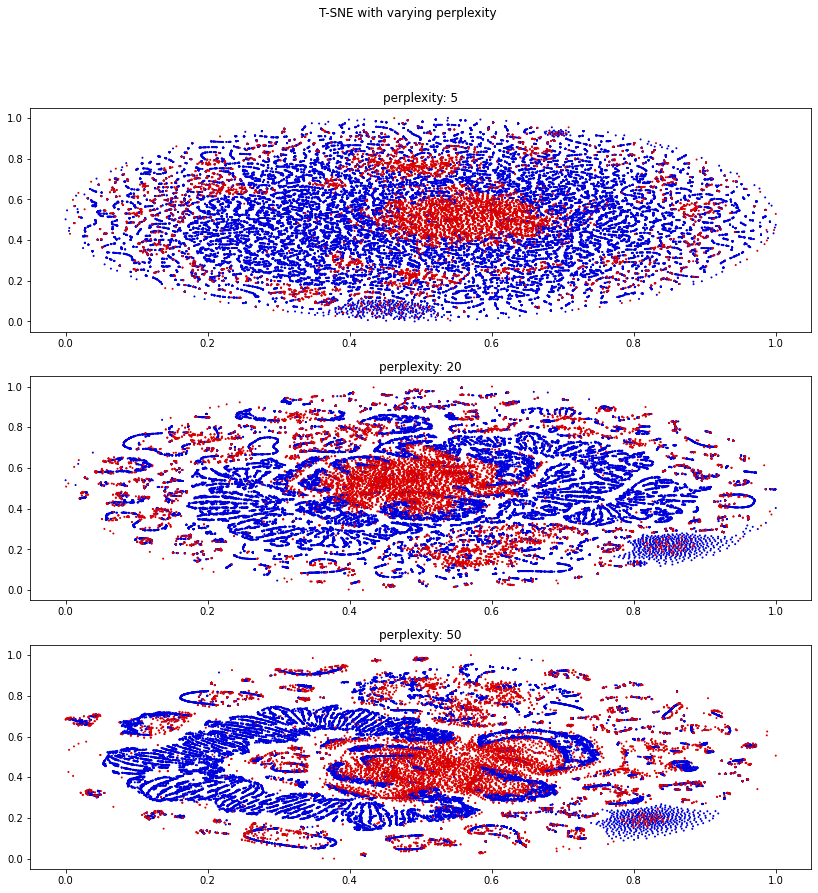

In [93]:
TEST_SIZE= CICIDS_train_X__no_attacks_augmented.shape[0] 
X=CICIDS_train_X__no_attacks_augmented[0:TEST_SIZE]
Y=CICIDS_train_Y__no_attacks_augmented[0:TEST_SIZE]
perplexity=[5, 20, 50]

# initialize a matplotlib plot
fig, (ax0, ax1, ax2) = plt.subplots(3)
fig.suptitle('T-SNE with varying perplexity')
fig.set_size_inches(14, 14)
colors=np.concatenate((Y,Y,Y), axis=1)
colors= np.where(colors==0, [0/255.0, 0/255.0, 220/255.0], [220/255.0, 0/255.0, 0/255.0])

tx, ty=compute_TSNE(perplexity[0], X)
ax0.scatter(tx, ty, c=colors, s=1)
ax0.set_title("perplexity: {}".format(perplexity[0]))

tx, ty=compute_TSNE(perplexity[1], X)
ax1.scatter(tx, ty,c=colors, s=1)
ax1.set_title("perplexity: {}".format(perplexity[1]))

tx, ty=compute_TSNE(perplexity[2], X)
ax2.scatter(tx, ty,c=colors, s=1)
ax2.set_title("perplexity: {}".format(perplexity[2]))

# finally, show the plot
plt.show()

### CTGAN

In [117]:
import ctgan
from ctgan.demo import load_demo
from ctgan.synthesizers.ctgan import CTGAN
pd.set_option('display.max_colwidth', None)
MKL_NUM_THREADS=6
OMP_NUM_THREADS=6
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
#from sklearn.utils.testing import ignore_warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [118]:
header=pd.read_csv("./datasets/CICIDS18_Shuffled_Reduced.csv")
header=header.drop(columns=['Timestamp', 'label'])

In [119]:
list(header.columns)

['Protocol',
 'Flow_Duration',
 'Tot_Fwd_Pkts',
 'Tot_Bwd_Pkts',
 'TotLen_Fwd_Pkts',
 'TotLen_Bwd_Pkts',
 'Fwd_Pkt_Len_Max',
 'Fwd_Pkt_Len_Min',
 'Fwd_Pkt_Len_Mean',
 'Fwd_Pkt_Len_Std',
 'Bwd_Pkt_Len_Max',
 'Bwd_Pkt_Len_Min',
 'Bwd_Pkt_Len_Mean',
 'Bwd_Pkt_Len_Std',
 'Flow_Bytss',
 'Flow_Pktss',
 'Flow_IAT_Mean',
 'Flow_IAT_Std',
 'Flow_IAT_Max',
 'Flow_IAT_Min',
 'Fwd_IAT_Tot',
 'Fwd_IAT_Mean',
 'Fwd_IAT_Std',
 'Fwd_IAT_Max',
 'Fwd_IAT_Min',
 'Bwd_IAT_Tot',
 'Bwd_IAT_Mean',
 'Bwd_IAT_Std',
 'Bwd_IAT_Max',
 'Bwd_IAT_Min',
 'Fwd_PSH_Flags',
 'Bwd_PSH_Flags',
 'Fwd_URG_Flags',
 'Bwd_URG_Flags',
 'Fwd_Header_Len',
 'Bwd_Header_Len',
 'Fwd_Pktss',
 'Bwd_Pktss',
 'Pkt_Len_Min',
 'Pkt_Len_Max',
 'Pkt_Len_Mean',
 'Pkt_Len_Std',
 'Pkt_Len_Var',
 'FIN_Flag_Cnt',
 'SYN_Flag_Cnt',
 'RST_Flag_Cnt',
 'PSH_Flag_Cnt',
 'ACK_Flag_Cnt',
 'URG_Flag_Cnt',
 'CWE_Flag_Count',
 'ECE_Flag_Cnt',
 'DownUp_Ratio',
 'Pkt_Size_Avg',
 'Fwd_Seg_Size_Avg',
 'Bwd_Seg_Size_Avg',
 'Fwd_Bytsb_Avg',
 'Fwd_Pktsb_Avg',
 'F

In [120]:
ctgan_trainX=CICIDS_train_X_no_attack.to_numpy()[:, 0:77]
ctgan_trainX=pd.DataFrame(ctgan_trainX, columns=list(header.columns))

In [121]:
#pd_ctgan_testX=pd.DataFrame(CICIDS_test_X[:, 0:77], columns=header.columns)

In [122]:
discrete_columns = ['Protocol',
                    'Fwd_PSH_Flags',
                    'Bwd_PSH_Flags',
                    'Fwd_URG_Flags',
                    'Bwd_URG_Flags',
                    'FIN_Flag_Cnt',
                    'SYN_Flag_Cnt',
                    'RST_Flag_Cnt',
                    'PSH_Flag_Cnt',
                    'ACK_Flag_Cnt',
                    'URG_Flag_Cnt',
                    'CWE_Flag_Count',
                    'ECE_Flag_Cnt',
                    'DownUp_Ratio',
                    'Fwd_Bytsb_Avg',
                    'Fwd_Pktsb_Avg',
                    'Fwd_Blk_Rate_Avg',
                    'Bwd_Bytsb_Avg',
                    'Bwd_Pktsb_Avg',
                    'Bwd_Blk_Rate_Avg']

In [127]:
ctgan = CTGAN(epochs=20, verbose=True)
ctgan.fit(ctgan_trainX, discrete_columns)

# Create synthetic data
X_ood = ctgan.sample(50000)
np.save('/home/notebook/attack_generation/saved_attacks_generated/cicids/CTGAN.npy', X_ood)


Epoch 1, Loss G: -1.1886,Loss D:  0.2413
Epoch 2, Loss G: -3.4788,Loss D:  0.2780
Epoch 3, Loss G: -4.7697,Loss D:  0.0592
Epoch 4, Loss G: -5.1435,Loss D:  0.3790
Epoch 5, Loss G: -5.4207,Loss D:  0.0431
Epoch 6, Loss G: -6.0848,Loss D: -0.0555
Epoch 7, Loss G: -4.6300,Loss D: -0.6217
Epoch 8, Loss G: -1.5873,Loss D: -1.6686
Epoch 9, Loss G:  0.5739,Loss D: -1.2468
Epoch 10, Loss G: -0.6508,Loss D: -0.5335
Epoch 11, Loss G: -1.0114,Loss D: -0.9473
Epoch 12, Loss G: -2.8363,Loss D:  0.2502
Epoch 13, Loss G: -4.0563,Loss D:  1.1041
Epoch 14, Loss G: -2.1867,Loss D:  0.6741
Epoch 15, Loss G: -1.7447,Loss D:  0.5034
Epoch 16, Loss G: -2.1771,Loss D: -0.4281
Epoch 17, Loss G: -1.6722,Loss D: -1.6542
Epoch 18, Loss G: -2.9645,Loss D:  0.7110
Epoch 19, Loss G: -1.8558,Loss D:  0.0119
Epoch 20, Loss G: -2.4479,Loss D: -1.5086


In [128]:
CICIDS_train_X__no_attacks_augmented=np.vstack((ctgan_trainX, X_ood))
CICIDS_train_Y__no_attacks_augmented=np.vstack((np.zeros((ctgan_trainX.shape[0],1)),
                                                 np.ones((X_ood.shape[0], 1))))

In [133]:
xb=xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False )
xb.fit(CICIDS_train_X__no_attacks_augmented, CICIDS_train_Y__no_attacks_augmented)
predicted=xb.predict(CICIDS_test_X.to_numpy()[:,0:77])

accuracy=accuracy_score(CICIDS_test_Y, predicted)
tn, fp, fn, tp = confusion_matrix(CICIDS_test_Y, predicted).ravel()
mcc=matthews_corrcoef(CICIDS_test_Y, predicted)
print("tp, tn, fp, fn, accuracy, mcc:")
tp, tn, fp, fn, accuracy, mcc

tp, tn, fp, fn, accuracy, mcc:


(0, 26998, 0, 132503, 0.16926539645519464, 0.0)

In [135]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
cicids_competitors.write(dataset+', '+
                       'CTGAN, '+
                       'XGBoost, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.to_numpy()[:,0:77].shape[1])+', '+
                       ' NO AUGMENTATION, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

In [136]:
contamination=0.2

total=int(CICIDS_train_X_no_attack.shape[0]*contamination)
if(total > X_ood.shape[0]):
    print("contamination is larger than the available attacks")
    sys.exit(0)

idx = np.random.randint(X_ood.shape[0], size=total)
attacks=X_ood.to_numpy()[idx,:]
CICIDS_train_X__no_attacks_augmented=np.vstack((ctgan_trainX, attacks))
CICIDS_train_Y__no_attacks_augmented=np.vstack((np.zeros((ctgan_trainX.shape[0], 1)),
                                                 np.ones((attacks.shape[0],1))))
                                                 
contamination=contamination/(1+contamination)
                                                 
contamination

0.16666666666666669

In [137]:
CICIDS_train_X_no_attack.shape

(40496, 121)

In [138]:
isol_1=IsolationForest(n_estimators=800,
                     max_samples='auto',
                     contamination=contamination,
                     max_features=1.0,
                     bootstrap=False,
                     n_jobs=12,warm_start=False).fit(CICIDS_train_X__no_attacks_augmented)

predicted=isol_1.predict(CICIDS_test_X.to_numpy()[:,0:77])

Y=CICIDS_test_Y
predicted=np.where(predicted==-1, 1, 0)
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(31868, 24285, 2713, 100635, 0.35205421909580503, 0.1274178745666876)

In [139]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
cicids_competitors.write(dataset+', '+
                       'CTGAN, '+
                       'Isolation Forest, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.to_numpy()[:,0:77].shape[1])+', '+
                       ' NO AUGMENTATION, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

In [140]:
clf = CBLOF(n_jobs=12, contamination=contamination)#, n_clusters=8
clf.fit(CICIDS_train_X__no_attacks_augmented)
predicted = clf.predict(CICIDS_test_X.to_numpy()[:,0:77])  # outlier labels (0 or 1)
Y=CICIDS_test_Y
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(1470, 24779, 2219, 131033, 0.16456950113165433, -0.17736841255440414)

In [141]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
cicids_competitors.write(dataset+', '+
                       'CTGAN, '+
                       'CBLOF, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.to_numpy()[:,0:77].shape[1])+', '+
                       ' NO AUGMENTATION, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

In [142]:
CICIDS_train_X_no_attack.shape, CICIDS_test_X.shape,CICIDS_test_Y.shape 

((40496, 121), (159501, 121), (159501, 1))

we apply some improvements:
- remove identical elements (are none; no effect)
- reduce to int (CHANGING SOMETHJING ON ISOLATION FOREST, BUT NOT STABLE)
- remove too close data

In [145]:
CICIDS_train_X__no_attacks_augmented=np.vstack((CICIDS_train_X_no_attack.to_numpy()[:, 0:77], X_ood))
CICIDS_train_Y__no_attacks_augmented=np.vstack((np.zeros((CICIDS_train_X_no_attack.shape[0], 1)),
                                                 np.ones((X_ood.shape[0],1))))

CICIDS_train_X__no_attacks_augmented.shape, X_ood.shape, CICIDS_train_X_no_attack.shape

((90496, 77), (50000, 77), (40496, 121))

In [146]:
#remove elements that are very close according to proximity evaluation
#proximity evaluation is multidimensional euclidean distance
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances

In [147]:
b=X_ood
a=CICIDS_train_X_no_attack.to_numpy()[:, 0:77]
a_length=CICIDS_train_X_no_attack.shape[0]
b_length=X_ood.shape[0]
ab=np.vstack((a,b))
abx, aby=compute_TSNE(5, ab)

In [148]:
ax=abx[:a_length]
ay=aby[:a_length]
bx=aby[a_length:]
by=aby[a_length:]

In [149]:
a_tsne=np.array((ax, ay)).T
b_tsne=np.array((bx, by)).T
res=np.zeros((b_tsne.shape[0],))
tmp=np.zeros(np.shape(a_tsne))
for i in range(0, b_tsne.shape[0]):
    if (i%5000 ==0):
        print(i)
    #TSNE 5 e distanza 0.001 sembrava OK come configurazione
    res[i]=(euclidean_distances(a_tsne, [b_tsne[i]])< 0.001).all(-1).any(-1)

c=b[np.array(res==False)]
# c is the new X_ood
c.shape

0
5000
10000
15000
20000
25000
30000
35000
40000
45000


(47003, 77)

In [150]:
X_ood=c
X_ood.shape

(47003, 77)

In [151]:
CICIDS_train_X__no_attacks_augmented=np.vstack((CICIDS_train_X_no_attack.to_numpy()[:, 0:77], X_ood))
CICIDS_train_Y__no_attacks_augmented=np.vstack((np.zeros((CICIDS_train_X_no_attack.shape[0],1)),
                                                 np.ones((X_ood.shape[0], 1))))

In [152]:
xb=xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False )
xb.fit(CICIDS_train_X__no_attacks_augmented, CICIDS_train_Y__no_attacks_augmented)
predicted=xb.predict(CICIDS_test_X.to_numpy()[:,0:77])

accuracy=accuracy_score(CICIDS_test_Y, predicted)
tn, fp, fn, tp = confusion_matrix(CICIDS_test_Y, predicted).ravel()
mcc=matthews_corrcoef(CICIDS_test_Y, predicted)
print("tp, tn, fp, fn, accuracy, mcc:")
tp, tn, fp, fn, accuracy, mcc

tp, tn, fp, fn, accuracy, mcc:


(0, 26997, 1, 132503, 0.16925912690202569, -0.00554710919960475)

In [154]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
cicids_competitors.write(dataset+', '+
                       'CTGAN, '+
                       'XGBoost, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.to_numpy()[:,0:77].shape[1])+', '+
                       ' attacks too close to normal are removed, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

In [155]:
contamination=0.2

total=int(CICIDS_train_X_no_attack.shape[0]*contamination)
if(total > X_ood.shape[0]):
    print("contamination is larger than the available attacks")
    sys.exit(0)

idx = np.random.randint(X_ood.shape[0], size=total)
attacks=X_ood.to_numpy()[idx,:]
CICIDS_train_X__no_attacks_augmented=np.vstack((CICIDS_train_X_no_attack.to_numpy()[:, 0:77], attacks))
CICIDS_train_Y__no_attacks_augmented=np.vstack((np.zeros((CICIDS_train_X_no_attack.shape[0], 1)),
                                                 np.ones((attacks.shape[0],1))))
                                                 
contamination=contamination/(1+contamination)
                                                 
contamination, attacks.shape

(0.16666666666666669, (8099, 77))

In [156]:
isol_1=IsolationForest(n_estimators=800,
                     max_samples='auto',
                     contamination=contamination,
                     max_features=1.0,
                     bootstrap=False,
                     n_jobs=12,warm_start=False).fit(CICIDS_train_X__no_attacks_augmented)

predicted=isol_1.predict(CICIDS_test_X.to_numpy()[:, 0:77])

Y=CICIDS_test_Y#.to_numpy().T[0]
predicted=np.where(predicted==-1, 1, 0)
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(32783, 24195, 2803, 99720, 0.35722660046018523, 0.12933129336380467)

In [157]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
cicids_competitors.write(dataset+', '+
                       'CTGAN, '+
                       'Isolation Forest, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.to_numpy()[:,0:77].shape[1])+', '+
                       ' attacks too close to normal are removed, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

In [158]:
clf = CBLOF(n_jobs=12, contamination=contamination)#, n_clusters=8
clf.fit(CICIDS_train_X__no_attacks_augmented)
predicted = clf.predict(CICIDS_test_X.to_numpy()[:, 0:77])  # outlier labels (0 or 1)
Y=CICIDS_test_Y#.to_numpy().T[0]
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(1466, 24795, 2203, 131037, 0.1646447357696817, -0.17643287951974235)

In [159]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
cicids_competitors.write(dataset+', '+
                       'CTGAN, '+
                       'CBLOF, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.to_numpy()[:,0:77].shape[1])+', '+
                       ' attacks too close to normal are removed, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

We visualize the generated data and the normal (original) data

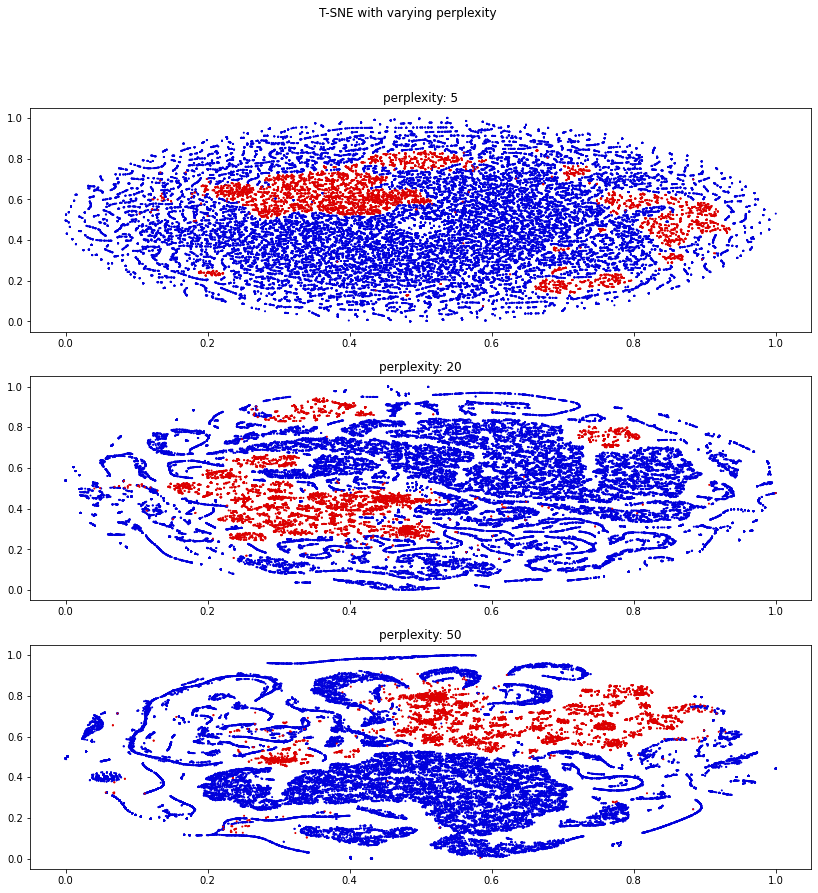

In [160]:
SIZE= CICIDS_train_X__no_attacks_augmented.shape[0]
X=CICIDS_train_X__no_attacks_augmented[0:SIZE]
Y=CICIDS_train_Y__no_attacks_augmented[0:SIZE]
perplexity=[5, 20, 50]

# initialize a matplotlib plot
fig, (ax0, ax1, ax2) = plt.subplots(3)
fig.suptitle('T-SNE with varying perplexity')
fig.set_size_inches(14, 14)
colors=np.concatenate((Y,Y,Y), axis=1)
colors= np.where(colors==0, 
                 [0/255.0, 0/255.0, 220/255.0], 
                 [220/255.0, 0/255.0, 0/255.0])

tx, ty=compute_TSNE(perplexity[0], X)
ax0.scatter(tx, ty, c=colors, s=1)
ax0.set_title("perplexity: {}".format(perplexity[0]))

tx, ty=compute_TSNE(perplexity[1], X)
ax1.scatter(tx, ty,c=colors, s=1)
ax1.set_title("perplexity: {}".format(perplexity[1]))

tx, ty=compute_TSNE(perplexity[2], X)
ax2.scatter(tx, ty,c=colors, s=1)
ax2.set_title("perplexity: {}".format(perplexity[2]))

# finally, show the plot
plt.show()

### ALAD

In [161]:
generated_attacks=np.load("/home/notebook/attack_generation/saved_attacks_generated/cicids/ALAD-egan.npy")

In [162]:
X_ood=generated_attacks
X_ood.shape

(50000, 121)

In [163]:
CICIDS_train_X__no_attacks_augmented=np.vstack((CICIDS_train_X_no_attack, X_ood))
CICIDS_train_Y__no_attacks_augmented=np.vstack((np.zeros((CICIDS_train_X_no_attack.shape[0],1)),
                                                 np.ones((X_ood.shape[0], 1))))

In [164]:
xb=xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False )
xb.fit(CICIDS_train_X__no_attacks_augmented, CICIDS_train_Y__no_attacks_augmented)
predicted=xb.predict(CICIDS_test_X)

accuracy=accuracy_score(CICIDS_test_Y, predicted)
tn, fp, fn, tp = confusion_matrix(CICIDS_test_Y, predicted).ravel()
mcc=matthews_corrcoef(CICIDS_test_Y, predicted)
print("tp, tn, fp, fn, accuracy, mcc:")
tp, tn, fp, fn, accuracy, mcc

tp, tn, fp, fn, accuracy, mcc:


(0, 26998, 0, 132503, 0.16926539645519464, 0.0)

In [165]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
cicids_competitors.write(dataset+', '+
                       'ALAD (eGAN), '+
                       'XGBOOST, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' NO AUGMENTATION, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

In [166]:
contamination=0.2

total=int(CICIDS_train_X_no_attack.shape[0]*contamination)
if(total > X_ood.shape[0]):
    print("contamination is larger than the available attacks")
    sys.exit(0)

idx = np.random.randint(X_ood.shape[0], size=total)
attacks=X_ood[idx,:]
CICIDS_train_X__no_attacks_augmented=np.vstack((CICIDS_train_X_no_attack, attacks))
CICIDS_train_Y__no_attacks_augmented=np.vstack((np.zeros((CICIDS_train_X_no_attack.shape[0], 1)),
                                                 np.ones((attacks.shape[0],1))))
                                                 
contamination=contamination/(1+contamination)
                                                 
contamination, attacks.shape

(0.16666666666666669, (8099, 121))

In [167]:
isol_1=IsolationForest(n_estimators=800,
                     max_samples='auto',
                     contamination=contamination,
                     max_features=1.0,
                     bootstrap=False,
                     n_jobs=12,warm_start=False).fit(CICIDS_train_X__no_attacks_augmented)

predicted=isol_1.predict(CICIDS_test_X)

Y=CICIDS_test_Y
predicted=np.where(predicted==-1, 1, 0)
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(49494, 21688, 5310, 83009, 0.4462793336718892, 0.13964014657599838)

In [168]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
cicids_competitors.write(dataset+', '+
                       'ALAD (eGAN), '+
                       'Isolation Forest, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' NO AUGMENTATION, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

In [169]:
clf = CBLOF(n_jobs=12, contamination=contamination)#, n_clusters=8
clf.fit(CICIDS_train_X__no_attacks_augmented)
predicted = clf.predict(CICIDS_test_X)  # outlier labels (0 or 1)
Y=CICIDS_test_Y
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(21694, 21624, 5374, 110809, 0.2715845041723876, -0.035290800789727274)

In [170]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
cicids_competitors.write(dataset+', '+
                       'ALAD (eGAN), '+
                       'CBLOF, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' NO AUGMENTATION, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

Now we apply improvements:
- remove identical elements (are none; no effect)
- reduce to int (CHANGING SOMETHJING ON ISOLATION FOREST, BUT NOT STABLE)
- remove too close data

In [171]:
generated_attacks=X_ood
X_ood.shape

(50000, 121)

In [172]:
#convert to int
X_ood=(np.rint(X_ood)).astype(int)


In [175]:
#remove identical elements from the generated attacks
a= CICIDS_train_X_no_attack.to_numpy()
b=X_ood
res = (b[:, None] == a).all(-1).any(-1)
c=b[np.array(res==False)]
X_ood=c
CICIDS_train_X_no_attack.shape, X_ood.shape

((40496, 121), (50000, 121))

In [176]:
CICIDS_train_X__no_attacks_augmented=np.vstack((CICIDS_train_X_no_attack, X_ood))
CICIDS_train_Y__no_attacks_augmented=np.vstack((np.zeros((CICIDS_train_X_no_attack.shape[0], 1)),
                                                 np.ones((X_ood.shape[0],1))))

CICIDS_train_X__no_attacks_augmented.shape, X_ood.shape, CICIDS_train_X_no_attack.shape

((90496, 121), (50000, 121), (40496, 121))

In [177]:
#remove elements that are very close according to proximity evaluation
#proximity evaluation is multidimensional euclidean distance
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances

In [178]:
b=X_ood
a=CICIDS_train_X_no_attack
a_length=CICIDS_train_X_no_attack.shape[0]
b_length=X_ood.shape[0]
ab=np.vstack((a,b))
abx, aby=compute_TSNE(50, ab)

In [179]:
ax=abx[:a_length]
ay=aby[:a_length]
bx=aby[a_length:]
by=aby[a_length:]

In [180]:
X_ood=c
X_ood.shape

(50000, 121)

In [181]:
CICIDS_train_X__no_attacks_augmented=np.vstack((CICIDS_train_X_no_attack, X_ood))
CICIDS_train_Y__no_attacks_augmented=np.vstack((np.zeros((CICIDS_train_X_no_attack.shape[0],1)),
                                                 np.ones((X_ood.shape[0], 1))))

In [182]:
xb=xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False )
xb.fit(CICIDS_train_X__no_attacks_augmented, CICIDS_train_Y__no_attacks_augmented)
predicted=xb.predict(CICIDS_test_X)

accuracy=accuracy_score(CICIDS_test_Y, predicted)
tn, fp, fn, tp = confusion_matrix(CICIDS_test_Y, predicted).ravel()
mcc=matthews_corrcoef(CICIDS_test_Y, predicted)
print("tp, tn, fp, fn, accuracy, mcc:")
tp, tn, fp, fn, accuracy, mcc

tp, tn, fp, fn, accuracy, mcc:


(0, 26998, 0, 132503, 0.16926539645519464, 0.0)

In [183]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
cicids_competitors.write(dataset+', '+
                       'ALAD (eGAN), '+
                       'XGBOOST, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' Remove identical elements, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

In [184]:
contamination=0.2

total=int(CICIDS_train_X_no_attack.shape[0]*contamination)
if(total > X_ood.shape[0]):
    print("contamination is larger than the available attacks")
    sys.exit(0)

idx = np.random.randint(X_ood.shape[0], size=total)
attacks=X_ood[idx,:]
CICIDS_train_X__no_attacks_augmented=np.vstack((CICIDS_train_X_no_attack, attacks))
CICIDS_train_Y__no_attacks_augmented=np.vstack((np.zeros((CICIDS_train_X_no_attack.shape[0], 1)),
                                                 np.ones((attacks.shape[0],1))))
                                                 
contamination=contamination/(1+contamination)
                                                 
contamination, attacks.shape

(0.16666666666666669, (8099, 121))

In [185]:
isol_1=IsolationForest(n_estimators=800,
                     max_samples='auto',
                     contamination=contamination,
                     max_features=1.0,
                     bootstrap=False,
                     n_jobs=12,warm_start=False).fit(CICIDS_train_X__no_attacks_augmented)

predicted=isol_1.predict(CICIDS_test_X)

Y=CICIDS_test_Y
predicted=np.where(predicted==-1, 1, 0)
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(57493, 21703, 5295, 75010, 0.49652353276781963, 0.18249972333786377)

In [186]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
cicids_competitors.write(dataset+', '+
                       'ALAD (eGAN), '+
                       'Isolation Forest, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' Remove identical elements, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

In [187]:
clf = CBLOF(n_jobs=12, contamination=contamination)#, n_clusters=8
clf.fit(CICIDS_train_X__no_attacks_augmented)
predicted = clf.predict(CICIDS_test_X)  # outlier labels (0 or 1)
Y=CICIDS_test_Y
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(2683, 21464, 5534, 129820, 0.1513909003705306, -0.3133732182475003)

In [188]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
cicids_competitors.write(dataset+', '+
                       'ALAD (eGAN), '+
                       'CBLOF, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' Remove identical elements, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

We visualize the generated data and the normal (original) data

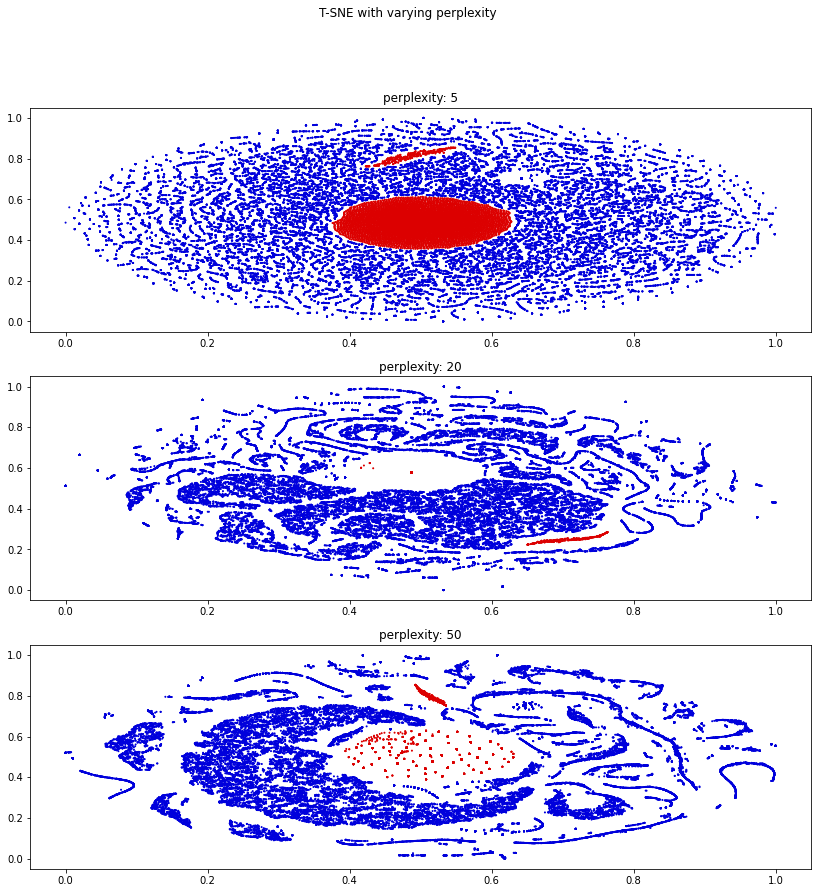

In [189]:
SIZE= CICIDS_train_X__no_attacks_augmented.shape[0]
X=CICIDS_train_X__no_attacks_augmented[0:SIZE]
Y=CICIDS_train_Y__no_attacks_augmented[0:SIZE]
perplexity=[5, 20, 50]

# initialize a matplotlib plot
fig, (ax0, ax1, ax2) = plt.subplots(3)
fig.suptitle('T-SNE with varying perplexity')
fig.set_size_inches(14, 14)
colors=np.concatenate((Y,Y,Y), axis=1)
colors= np.where(colors==0, 
                 [0/255.0, 0/255.0, 220/255.0], 
                 [220/255.0, 0/255.0, 0/255.0])

tx, ty=compute_TSNE(perplexity[0], X)
ax0.scatter(tx, ty, c=colors, s=1)
ax0.set_title("perplexity: {}".format(perplexity[0]))

tx, ty=compute_TSNE(perplexity[1], X)
ax1.scatter(tx, ty,c=colors, s=1)
ax1.set_title("perplexity: {}".format(perplexity[1]))

tx, ty=compute_TSNE(perplexity[2], X)
ax2.scatter(tx, ty,c=colors, s=1)
ax2.set_title("perplexity: {}".format(perplexity[2]))

# finally, show the plot
plt.show()

### Now we use Gaussian Copulas

In [190]:
train_X_no_attack=pd.DataFrame(CICIDS_train_X_no_attack, columns=np.arange(0,CICIDS_train_X_no_attack.shape[1]))
#train_X_no_attack.head()

In [193]:
from copulas.multivariate import GaussianMultivariate

from numpy import inf
train_X_no_attack=np.nan_to_num(train_X_no_attack, copy=True, nan=0.0, posinf=0, neginf=0)

dist = GaussianMultivariate()
dist.fit(train_X_no_attack)

In [194]:
X_ood = dist.sample(15000)
X_ood=np.nan_to_num(X_ood, copy=True, nan=0.0, posinf=0, neginf=0)


In [195]:
from copulas.visualization import compare_3d
#compare_3d(train_X_no_attack, X_ood)

In [196]:
X_ood

array([[-0.01157468,  1.01886203, -0.00675346, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00771105,  0.9327749 ,  0.9099606 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.01502801,  1.02100398, -0.0051981 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.00810722,  0.99717989,  0.01155907, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00908996,  0.9462238 ,  0.03716384, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00211024,  0.99931484,  0.00247894, ...,  0.        ,
         0.        ,  0.        ]])

In [197]:
np.save('/home/notebook/gaussianCopula.npy', X_ood)

In [198]:
CICIDS_train_X__no_attacks_augmented=np.vstack((CICIDS_train_X_no_attack, X_ood))
CICIDS_train_Y__no_attacks_augmented=np.vstack((np.zeros((CICIDS_train_X_no_attack.shape[0],1)),
                                                 np.ones((X_ood.shape[0], 1))))

In [199]:
from numpy import inf
CICIDS_train_X__no_attacks_augmented[CICIDS_train_X__no_attacks_augmented == -inf] = 0.0
CICIDS_train_X__no_attacks_augmented[CICIDS_train_X__no_attacks_augmented == inf] = 0.0
CICIDS_train_X__no_attacks_augmented[np.isnan(CICIDS_train_X__no_attacks_augmented)] = 0.0

xb=xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False )
xb.fit(CICIDS_train_X__no_attacks_augmented, CICIDS_train_Y__no_attacks_augmented)
predicted=xb.predict(CICIDS_test_X)

accuracy=accuracy_score(CICIDS_test_Y, predicted)
tn, fp, fn, tp = confusion_matrix(CICIDS_test_Y, predicted).ravel()
mcc=matthews_corrcoef(CICIDS_test_Y, predicted)
print("tp, tn, fp, fn, accuracy, mcc:")
tp, tn, fp, fn, accuracy, mcc

tp, tn, fp, fn, accuracy, mcc:


(0, 26998, 0, 132503, 0.16926539645519464, 0.0)

In [200]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
cicids_competitors.write(dataset+', '+
                       'gaussian copulas, '+
                       'XGBoost, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' NO AUGMENTATION, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

In [203]:
contamination=0.2

total=int(CICIDS_train_X_no_attack.shape[0]*contamination)
if(total > X_ood.shape[0]):
    print("contamination is larger than the available attacks")
    sys.exit(0)

idx = np.random.randint(X_ood.shape[0], size=total)
attacks=X_ood[idx,:]
CICIDS_train_X__no_attacks_augmented=np.vstack((CICIDS_train_X_no_attack, attacks))
CICIDS_train_Y__no_attacks_augmented=np.vstack((np.zeros((CICIDS_train_X_no_attack.shape[0], 1)),
                                                 np.ones((attacks.shape[0],1))))
                                                 
contamination=contamination/(1+contamination)
                                                 
contamination

0.16666666666666669

In [204]:
isol_1=IsolationForest(n_estimators=300,
                     max_samples='auto',
                     contamination=contamination,
                     max_features=1.0,
                     bootstrap=False,
                     n_jobs=12,warm_start=False).fit(CICIDS_train_X__no_attacks_augmented)

predicted=isol_1.predict(CICIDS_test_X)

Y=CICIDS_test_Y
predicted=np.where(predicted==-1, 1, 0)
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(56688, 22917, 4081, 75815, 0.4990877800139184, 0.21363025178718636)

In [205]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
cicids_competitors.write(dataset+', '+
                       'gaussian copulas, '+
                       'Isolation Forest, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' NO AUGMENTATION, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

In [206]:
clf = CBLOF(n_jobs=12, contamination=contamination)#, n_clusters=8
clf.fit(CICIDS_train_X__no_attacks_augmented)
predicted = clf.predict(CICIDS_test_X)  # outlier labels (0 or 1)
Y=CICIDS_test_Y
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(21694, 21624, 5374, 110809, 0.2715845041723876, -0.035290800789727274)

In [207]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
cicids_competitors.write(dataset+', '+
                       'gaussian copulas, '+
                       'CBLOF, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' NO AUGMENTATION, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

We remove identical elements and elements too close to the normal ones. This is important to do here, because Copula is not for generating OOD, but tries to generate data as similar as possibile to the normal distribution.

In [208]:
#remove elements that are very close according to proximity evaluation
#proximity evaluation is multidimensional euclidean distance
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances

In [209]:
X_ood[X_ood == -inf] = 0.0
X_ood[X_ood == inf] = 0.0
X_ood[np.isnan(X_ood)] = 0.0

b=X_ood
a=CICIDS_train_X_no_attack
a_length=CICIDS_train_X_no_attack.shape[0]
b_length=X_ood.shape[0]

ab=np.vstack((a,b))

abx, aby=compute_TSNE(50, ab)#prima lo ho testato con 5

In [210]:
ax=abx[:a_length]
ay=aby[:a_length]
bx=aby[a_length:]
by=aby[a_length:]

In [211]:
a_tsne=np.array((ax, ay)).T
b_tsne=np.array((bx, by)).T
res=np.zeros((b_tsne.shape[0],))
tmp=np.zeros(np.shape(a_tsne))
for i in range(0, b_tsne.shape[0]):
    if (i%5000 ==0):
        print(i)
    #TSNE 5 e distanza 0.001 sembrava OK come configurazione
    res[i]=(euclidean_distances(a_tsne, [b_tsne[i]])< 0.02).all(-1).any(-1)

c=b[np.array(res==False)]
# c is the new X_ood
c.shape

0
5000
10000


(1330, 121)

In [218]:
CICIDS_train_X__no_attacks_augmented=np.vstack((CICIDS_train_X_no_attack, c))
CICIDS_train_Y__no_attacks_augmented=np.vstack((np.zeros((CICIDS_train_X_no_attack.shape[0],1)),
                                                 np.ones((c.shape[0], 1))))

In [219]:
xb=xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False )
xb.fit(CICIDS_train_X__no_attacks_augmented, CICIDS_train_Y__no_attacks_augmented)
predicted=xb.predict(CICIDS_test_X)

accuracy=accuracy_score(CICIDS_test_Y, predicted)
tn, fp, fn, tp = confusion_matrix(CICIDS_test_Y, predicted).ravel()
mcc=matthews_corrcoef(CICIDS_test_Y, predicted)
print("tp, tn, fp, fn, accuracy, mcc:")
tp, tn, fp, fn, accuracy, mcc

tp, tn, fp, fn, accuracy, mcc:


(0, 26998, 0, 132503, 0.16926539645519464, 0.0)

In [220]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
cicids_competitors.write(dataset+', '+
                       'gaussian copulas, '+
                       'XGBOOST, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' Remove elements too close, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

In [221]:
contamination=0.2

idx = np.random.randint(c.shape[0], size=total)
attacks=c[idx,:]
CICIDS_train_X__no_attacks_augmented=np.vstack((CICIDS_train_X_no_attack, attacks))
CICIDS_train_Y__no_attacks_augmented=np.vstack((np.zeros((CICIDS_train_X_no_attack.shape[0], 1)),
                                                 np.ones((attacks.shape[0],1))))
                                                 
contamination=contamination/(1+contamination)
                                                 
contamination

0.16666666666666669

In [222]:
isol_1=IsolationForest(n_estimators=300,
                     max_samples='auto',
                     contamination=contamination,
                     max_features=1.0,
                     bootstrap=False,
                     n_jobs=12,warm_start=False).fit(CICIDS_train_X__no_attacks_augmented)

predicted=isol_1.predict(CICIDS_test_X)

Y=CICIDS_test_Y
predicted=np.where(predicted==-1, 1, 0)
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(57619, 22237, 4761, 74884, 0.5006614378593238, 0.19864008377377945)

In [223]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
cicids_competitors.write(dataset+', '+
                       'gaussian copulas, '+
                       'Isolation Forest, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' Remove elements too close, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

In [224]:
clf = CBLOF(n_jobs=12, contamination=contamination)#, n_clusters=8
clf.fit(CICIDS_train_X__no_attacks_augmented)
predicted = clf.predict(CICIDS_test_X)  # outlier labels (0 or 1)
Y=CICIDS_test_Y
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(21694, 21623, 5375, 110809, 0.2715782346192187, -0.03532728324186253)

In [225]:
dataset='cicids'
normal_in_training_set=np.unique(CICIDS_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(CICIDS_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
cicids_competitors.write(dataset+', '+
                       'gaussian copulas, '+
                       'CBLOF, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' Remove elements too close, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

### ARN - Adversarial Regularized Reconstruction for Anomaly Detection and Generation

In [226]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler


def _encode_text_dummy(df, name):
    
    names = []
    dummies = pd.get_dummies(df.loc[:,name])
    i = 0
    
    tmpL = []
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df.loc[:, dummy_name] = dummies[x]
        names.append(dummy_name)
        _x = [i, x]
        tmpL.append(_x)
        i += 1
    
    df.drop(name, axis=1, inplace=True)
    return names, tmpL

def _to_xy(df, target):
    """Converts a Pandas dataframe to the x,y inputs"""
    y = df[target]
    x = df.drop(columns=target)
    return x, y



In [227]:
seed = 42

In [228]:
generated_attacks_ARN=np.load('/home/notebook/attack_generation/saved_attacks_generated/cicids/arn.npy')

In [229]:
x_train=np.load('/home/notebook/attack_generation/saved_attacks_generated/cicids/ARN_x_train.npy')
y_train=np.load('/home/notebook/attack_generation/saved_attacks_generated/cicids/ARN_y_train.npy')
x_test=np.load('/home/notebook/attack_generation/saved_attacks_generated/cicids/ARN_x_test.npy')
y_test=np.load('/home/notebook/attack_generation/saved_attacks_generated/cicids/ARN_y_test.npy')

In [230]:
x_test.min(), x_test.max() 

(0.0, 181.74908)

In [231]:
x_train_augmented=np.vstack((x_train,generated_attacks_ARN))

y_train_augmented=np.hstack((y_train,
                             np.ones(generated_attacks_ARN.shape[0],)))

In [232]:
xb=xgb.XGBClassifier(objective='binary:logistic', 
                     use_label_encoder=False )
xb.fit(x_train_augmented, 
       y_train_augmented)

predicted=xb.predict(x_test)

accuracy=accuracy_score(y_test, predicted)
tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
mcc=matthews_corrcoef(y_test, predicted)
print("tp, tn, fp, fn, accuracy, mcc:")
tp, tn, fp, fn, accuracy, mcc

tp, tn, fp, fn, accuracy, mcc:


(0, 26998, 0, 66252, 0.2895227882037534, 0.0)

In [233]:
predicted

array([0, 0, 0, ..., 0, 0, 0])

In [234]:
dataset='cicids'
normal_in_training_set=np.unique(x_train.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(y_test, return_counts=True)[1][0]
attacks_in_test_set=np.unique(y_test, return_counts=True)[1][1]
generated_attacks=generated_attacks_ARN.shape[0]
cicids_competitors.write(dataset+', '+
                       'ARN, '+
                       'XGBoost, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' NO AUGMENTATION, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

In [235]:
contamination=0.2

total=int(x_train.shape[0]*contamination)
if(total > generated_attacks_ARN.shape[0]):
    print("contamination is larger than the available attacks")
    sys.exit(0)
    
generated_attacks1=shuffle(generated_attacks_ARN)

idx = np.random.randint(generated_attacks1.shape[0], size=total)
attacks=generated_attacks1[idx,:]
x_train_augmented=np.vstack((x_train, attacks))
y_train_augmented=np.hstack((y_train,np.ones((attacks.shape[0],))))
                                                 
contamination=contamination/(1+contamination)
                                                 
contamination

0.16666666666666669

In [236]:
isol_1=IsolationForest(n_estimators=300,
                     max_samples='auto',
                     contamination=contamination,
                     max_features=1.0,
                     bootstrap=False,
                     n_jobs=12,warm_start=False).fit(x_train_augmented)

predicted=isol_1.predict(x_test)

Y=y_test
predicted=np.where(predicted==-1, 1, 0)
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(31271, 22052, 4946, 34981, 0.571828418230563, 0.26874864282951594)

In [237]:
dataset='cicids'
normal_in_training_set=np.unique(x_train.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(y_test, return_counts=True)[1][0]
attacks_in_test_set=np.unique(y_test, return_counts=True)[1][1]
generated_attacks=generated_attacks_ARN.shape[0]
cicids_competitors.write(dataset+', '+
                       'ARN, '+
                       'Isolation Forest, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' NO AUGMENTATION, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()

In [238]:
clf = CBLOF(n_jobs=12, contamination=contamination)#, n_clusters=8
clf.fit(x_train_augmented)
predicted = clf.predict(x_test)  # outlier labels (0 or 1)
Y=y_test
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(16959, 21875, 5123, 49293, 0.41645040214477214, 0.0706494042294381)

In [239]:
dataset='cicids'
normal_in_training_set=np.unique(x_train.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(y_test, return_counts=True)[1][0]
attacks_in_test_set=np.unique(y_test, return_counts=True)[1][1]
generated_attacks=generated_attacks_ARN.shape[0]
cicids_competitors.write(dataset+', '+
                       'ARN, '+
                       'CBLOF, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(CICIDS_test_X.shape[1])+', '+
                       ' NO AUGMENTATION, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
cicids_competitors.flush()